In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import surprise
import math

%matplotlib inline

In [ ]:
rating_df = pd.read_csv('../input/anime-recommendations-database/rating.csv')
anime_df = pd.read_csv('../input/anime-recommendations-database/anime.csv')
# anime_with_synopsis = pd.read_csv('../input/anime-recommendation-database-2020/anime_with_synopsis.csv')
# anime_with_synopsis.drop(['MAL_ID', 'Score', 'Genders'], axis=1, inplace=True)
# anime_with_synopsis = anime_with_synopsis.rename(columns={"Name": "name"})
# anime_df = anime_df.merge(anime_with_synopsis, on=["name"])
# # anime_with_synopsis.head(5)

print('rating_df shape:', rating_df.shape)
print('anime_df shape:', anime_df.shape)
anime_df.drop(['rating'], axis=1, inplace=True)




In [ ]:
rating_df = rating_df[rating_df['user_id'] <= 10000] 
rating_df.head()

In [ ]:
anime_df.head()

## Небольшое исследование данных

In [ ]:
rating_df.describe() # немного статистики

In [ ]:
#  rating_df.rating.hist()

In [ ]:
data = rating_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / rating_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
layout = dict(title = 'Distribution Of {} anime-ratings'.format(rating_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

## В реальности многие пользователи не хотят выставлять оценку по какой-либо причине, может быть, потому что они ленивы. -1 означает, что пользователь смотрел аниме, но не присвоил рейтинг, поэтому удаляем это.

In [ ]:
rating_df = rating_df.loc[rating_df['rating'] != -1]
len(rating_df)

In [ ]:
data = rating_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / rating_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
layout = dict(title = 'Distribution Of {} anime-ratings'.format(rating_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# 1 шаг. Получить user-item матрицу

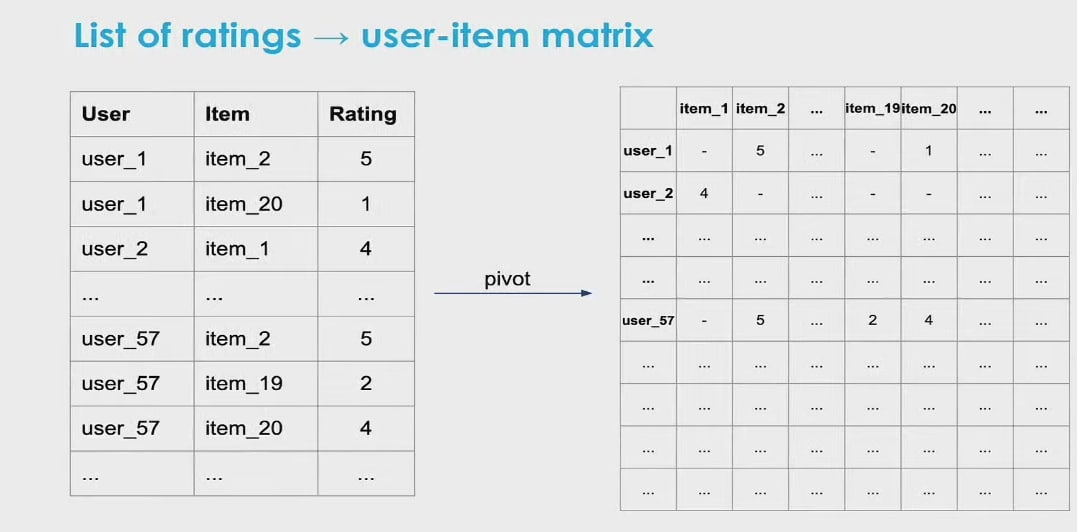

<!-- ![image.png](attachment:82a52cb0-99c8-45d2-afb0-20a0a2a7bfe3.png) -->

In [ ]:
# # Вообще для удобства лучше кодировать id пользователей и аниме числами от 0 до к-ва уникальных значений. Делаем это с помощью LabelEncoder
# from sklearn.preprocessing import LabelEncoder
# enc_user = LabelEncoder() #создаем экз. класса
# enc_anime = LabelEncoder()
# enc_user = enc_user.fit(rating_df.user_id.values)
# enc_anime = enc_anime.fit(rating_df.anime_id.values)
# # сделаем переобозначения
# rating_df.loc[:, 'user_id'] = enc_user.transform(rating_df.loc[:,'user_id'].values)
# rating_df.loc[:, 'anime_id'] = enc_anime.transform(rating_df.loc[:,'anime_id'].values)
# rating_df.anime_id.nunique()

In [ ]:
user_item_df = rating_df.pivot_table(index='user_id', columns='anime_id', values='rating')


In [ ]:
user_item_df.head()

### Наглядно видим, что матарица очень разреженна

In [ ]:
user_item_df.describe()

### Мы можем вывести, например, рейтинг userId = 5 для первых 10 фильмов 

In [ ]:
user_item_df.loc[5][:10]

In [ ]:
# список id аниме, которые пользователь оценил
item_rated_user_5 = user_item_df.loc[5].dropna().index
item_rated_user_5

### Мы хотим найти матрицу ранга k, наиболее близкую к исходной матрице.

# Заполняем нулями или средними значениями, затем используем сингулярное разложение(SVD). Нельзя это применять к разреженной матрице.

In [ ]:
user_item_df = user_item_df.fillna(0)
user_item_df.head()

In [ ]:
R = user_item_df.values # помещаем в массив
R

<h3 style="background-color:orange;font-family:newtimeroman;font-size:250%;text-align:center;border-radius: 15px 50px;"> Немного теории </h3>

# Применяем SVD (матричное разложение по норме Фробениуса) к R

Singular Value Decomposition decomposes a matrix $R$ into the best lower rank (i.e. smaller/simpler) approximation of the original matrix $R$. Mathematically, it decomposes R into a two unitary matrices and a diagonal matrix:

$$\begin{equation}
R = U\Sigma V^{T}
\end{equation}$$

where: 
- R is users's ratings matrix, 
- $U$ is the user "features" matrix, it represents how much users "like" each feature,
- $\Sigma$ is the diagonal matrix of singular values (essentially weights), 
- $V^{T}$ is the movie "features" matrix, it represents how relevant each feature is to each movie,

with $U$ and $V^{T}$ orthogonal.

p.s Факторный анализ – это процедура, с помощью которой большое число переменных, относящихся к имеющимся наблюдениям, сводят к меньшемуколичеству независимых влияющих величин, называемых факторами:• в один фактор объединяются переменные, сильно коррелирующие между
собой. • переменные из разных факторов слабо коррелируют между собой.
Фактор (Factor) – латентная (скрытая) переменная, конструируемая таким образом,
чтобы можно было объяснить корреляцию между набором имеющихся переменных.


# Факторизация матрицы

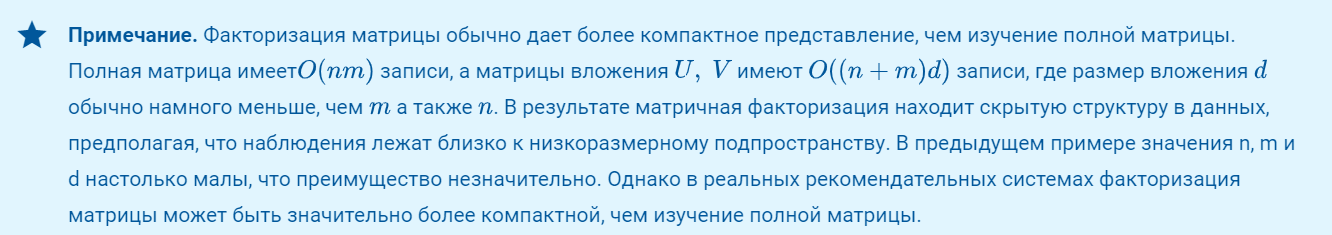

### Выбор целевой функции
#### Одна интуитивно понятная целевая функция - это квадрат расстояния. Для этого минимизируют сумму квадратов ошибок по всем парам наблюдаемых записей:
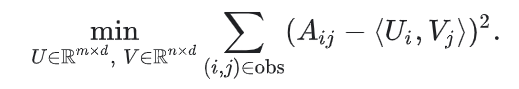
#### В этой целевой функции мы суммируем только наблюдаемые пары (i, j), то есть ненулевые значения в матрице обратной связи. Однако суммирование значений только одного значения не является хорошей идеей - матрица всех значений будет иметь минимальные потери и даст модель, которая не может давать эффективные рекомендации и плохо обобщает.
#### ПОЭТОМУ мы выше рассмотрели ненаблюдаемые значения как *ноль* и будем суммировать все записи в матрице. Это соответствует минимизации квадрата расстояния Фробениуса между А и Vt
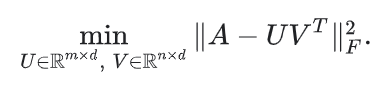
#### Попробуем решить эту квадратичную задачу с помощью разложения по сингулярным значениям ( SVD ) матрицы. 

In [ ]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(user_item_df, k = 50) #k- к-во латентных факторов

In [ ]:
U #это матрица "функций" пользователя, она показывает, насколько пользователям "нравится" каждая функция,

In [ ]:
sigma #диагональная матрица сингулярных значений (по сути, весов)

In [ ]:
Vt #это матрица "характеристик" фильма, она показывает, насколько каждая функция актуальна для каждого фильма,

### Sigma - это просто значения, а не диагональная матрица. Это полезно, но поскольку я собираюсь использовать умножение матриц для получения рекомендаций, конвертируем её в  диагональную матрицу.

In [ ]:
sigma = np.diag(sigma)

In [ ]:
R_after_svd = np.dot(np.dot(U, sigma), Vt)
R_after_svd

In [ ]:
R_after_svd_df = pd.DataFrame(R_after_svd, columns = user_item_df.columns)
R_after_svd_df.head()


In [ ]:
def recommend_movies(predictions_df, user_id, anime_id, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = user_id - 1 # UserID starts at 1, not 0
    sorted_user_predictions = R_after_svd_df.iloc[user_row_number].sort_values(ascending=False) # UserID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == (user_id)]
    user_full = (user_data.merge(anime_id, how = 'left', left_on = 'anime_id', right_on = 'anime_id').
                     sort_values(['rating'], ascending=False)
                 )

    print ( 'User {0} has already rated {1} movies.'.format(user_id, user_full.shape[0]))
    print ('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (anime_id[~anime_id['anime_id'].isin(user_full['anime_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'anime_id',
               right_on = 'anime_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [ ]:
already_rated, predictions = recommend_movies(R_after_svd, 123, anime_df, rating_df, 10)

In [ ]:
already_rated.head(10)

In [ ]:
from collections import defaultdict

all_genres = defaultdict(int)

for genres in already_rated['genre']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

In [ ]:
from wordcloud import WordCloud

genres_cloud = WordCloud(width=800, height=400, background_color='white', colormap='gnuplot').generate_from_frequencies(all_genres)

plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [ ]:
predictions

## Пользователь любит экшн, драму, комедии. Рекомендательная система выдала ему фильмы именно таких жанров, которые он любит

Однако SVD - тоже не лучшее решение, потому что в реальных приложениях матрица может быть очень редкой. Например, подумайте обо всех видео на YouTube по сравнению со всеми видео, которые просмотрел конкретный пользователь. Решение Vt (что соответствует аппроксимации входной матрицы моделью), вероятно, будет близко к нулю, что приведет к плохой производительности обобщения.

### Недостатки такого подхода:

* недостающие значения (здесь заполнены нулями) - это обратная связь, которую пользователь не давал, мы не должны считать ее отрицательной / нулевой оценкой.
* матрица огромна, применение SVD не масштабируется.

# Approximate SVD with stochastic gradient descend (SGD)
### В этот раз мы **не** заполняем пропущенные значения.

### Мы вводим $\Sigma$ в U и V, и пытаемся найти P и q такие что $\widehat{R} = P Q^{T}$ близко к  $R$ **для уже оцененных пар item-user**.

##### Первая функция для упрощения записей (userId / itemId):

In [ ]:
def encode_ids(data):
    ''' Принимает фрейм данных рейтинга и возвращает:
     -  упрощенный фрейм данных рейтинга с идентификаторами в диапазоне (к-во уникальный идентификатор) для пользователей и фильмов
     -  2 mapping словаря
    
    '''

    data_encoded = data.copy()
    
    users = pd.DataFrame(data_encoded.user_id.unique(),columns=['user_id'])  # df of all unique users
    dict_users = users.to_dict()    
    inv_dict_users = {v: k for k, v in dict_users['user_id'].items()}

    items = pd.DataFrame(data_encoded.anime_id.unique(),columns=['anime_id']) # df of all unique items
    dict_items = items.to_dict()    
    inv_dict_items = {v: k for k, v in dict_items['anime_id'].items()}

    data_encoded.user_id = data_encoded.user_id.map(inv_dict_users)
    data_encoded.anime_id = data_encoded.anime_id.map(inv_dict_items)

    return data_encoded, dict_users, dict_items

# Алгоритм
Вот процедура, которую мы хотели бы реализовать в функции SGD ():

1. Приписываем P и Q в случайные значения

2. заданное количество раз (т. е. количество эпох) повторите:

     * для всех известных рейтингов $ r_ {ui} $: 
         * вычислить ошибку между прогнозируемым рейтингом pu * qi и известным рейтином rui:
         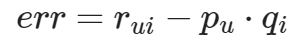
         * обновите pu и qi по следующему правилу:
       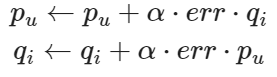

In [ ]:
def SGD1(data,           # датафрейм содержащий 1 пользователя | элемент | рейтинг в строке
        n_factors = 20, # количество факторов
        alpha =  0.001,   
        n_epochs = 5,   # количество итераций процедуры SGD
       ):
    '''Обучаем вектор P и Q (ie all the weights p_u and q_i) с SGD.
    '''
    epoch_count = range(1, n_epochs+1)
    # Кодирование userId и itemId
    data, dict_users, dict_items = encode_ids(data)
    
    n_users = data.user_id.nunique()  # к-во уникальных пользователей
    n_items = data.anime_id.nunique()  # к-во уникальных аниме
   
    
    # Рандомно инициализируем факторы пользователя и элемента
    p = np.random.normal(0, .1, (n_users, n_factors))
    q = np.random.normal(0, .1, (n_items, n_factors))
    
    list_err = []
    # Процедура оптимизации
    for epoch in range(n_epochs):
        print ('epoch: ', epoch)
        sum_kvadrat_err = 0
        n = 0
        # Перебираем строки в данных
        for index in range(data.shape[0]):
            row = data.iloc[[index]]
            u = int(row.user_id)      # current userId = позиция в векторе p (благодаря кодировке)
            i = int(row.anime_id)      # current itemId = позиция в векторе q
            r_ui = float(row.rating) # рейтинг, связанный с парой (user u , item i)
               
            err = r_ui - np.dot(p[u],(q[i]).transpose(), out=None)    # разница между прогнозируемым рейтингом (p_u. q_i) и известным рейтингом r_ui         
            kvadrat_err = err * err
            n += 1
            sum_kvadrat_err += kvadrat_err
            # Обновляем векторы p_u и q_i
            p_old = p[u]
            p[u] = p[u] + alpha * err * q[i]
            q[i] = q[i] + alpha * err * p_old  
        sum_kvadrat_err_n =  sum_kvadrat_err / n
        rmse = math.sqrt(sum_kvadrat_err_n)
        list_err.append(rmse)
        print(rmse)       
    plt.plot(epoch_count, (list_err), 'g--')
    return p, q
    
    
def estimate(u, i, p, q):
    '''Оцениваем рейтинг пользователя u для аниме i.'''
     
    return np.dot(p[u],q[i].transpose())           ## скалярное произведение  p[u] and q[i] /!\ dimensions
   

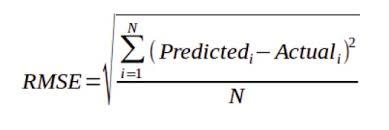


In [ ]:
%%time
p1, q1 = SGD1(rating_df)

In [ ]:
def SGD2(data,           # датафрейм содержащий 1 пользователя | элемент | рейтинг в строке
        n_factors = 10, # количество факторов
        alpha = 0.001,   
        n_epochs = 5,   # количество итераций процедуры SGD
       ):
    '''Обучаем вектор P и Q (ie all the weights p_u and q_i) с SGD.
    '''
    epoch_count = range(1, n_epochs+1)
    # Кодирование userId и itemId
    data, dict_users, dict_items = encode_ids(data)
    
    n_users = data.user_id.nunique()  # к-во уникальных пользователей
    n_items = data.anime_id.nunique()  # к-во уникальных аниме
   
    
    # Рандомно инициализируем факторы пользователя и элемента
    p = np.random.normal(0, .1, (n_users, n_factors))
    q = np.random.normal(0, .1, (n_items, n_factors))
    
    list_err = []
    # Процедура оптимизации
    for epoch in range(n_epochs):
        print ('epoch: ', epoch)
        sum_kvadrat_err = 0
        n = 0
        # Перебираем строки в данных
        for index in range(data.shape[0]):
            row = data.iloc[[index]]
            u = int(row.user_id)      # current userId = позиция в векторе p (благодаря кодировке)
            i = int(row.anime_id)      # current itemId = позиция в векторе q
            r_ui = float(row.rating) # рейтинг, связанный с парой (user u , item i)
               
            err = r_ui - np.dot(p[u],(q[i]).transpose(), out=None)    # разница между прогнозируемым рейтингом (p_u. q_i) и известным рейтингом r_ui         
            kvadrat_err = err * err
            n += 1
            sum_kvadrat_err += kvadrat_err
            # Обновляем векторы p_u и q_i
            p_old = p[u]
            p[u] = p[u] + alpha * err * q[i]
            q[i] = q[i] + alpha * err * p_old  
        sum_kvadrat_err_n =  sum_kvadrat_err / n
        rmse = math.sqrt(sum_kvadrat_err_n)
        list_err.append(rmse)
        print(rmse)       
    plt.plot(epoch_count, (list_err), 'g--')
    return p, q
    
    
def estimate(u, i, p, q):
    '''Оцениваем рейтинг пользователя u для аниме i.'''
     
    return np.dot(p[u],q[i].transpose())           ## скалярное произведение  p[u] and q[i] /!\ dimensions
   

In [ ]:
%%time
p2, q2 = SGD2(rating_df)

In [ ]:
def SGD3(data,           # датафрейм содержащий 1 пользователя | элемент | рейтинг в строке
        n_factors = 15, # количество факторов
        alpha = 0.001,    
        n_epochs = 10,   # количество итераций процедуры SGD
       ):
    '''Обучаем вектор P и Q (ie all the weights p_u and q_i) с SGD.
    '''
    epoch_count = range(1, n_epochs+1)
    # Кодирование userId и itemId
    data, dict_users, dict_items = encode_ids(data)
    
    n_users = data.user_id.nunique()  # к-во уникальных пользователей
    n_items = data.anime_id.nunique()  # к-во уникальных аниме
   
    
    # Рандомно инициализируем факторы пользователя и элемента
    p = np.random.normal(0, .1, (n_users, n_factors))
    q = np.random.normal(0, .1, (n_items, n_factors))
    
    list_err = []
    # Процедура оптимизации
    for epoch in range(n_epochs):
        print ('epoch: ', epoch)
        sum_kvadrat_err = 0
        n = 0
        # Перебираем строки в данных
        for index in range(data.shape[0]):
            row = data.iloc[[index]]
            u = int(row.user_id)      # current userId = позиция в векторе p (благодаря кодировке)
            i = int(row.anime_id)      # current itemId = позиция в векторе q
            r_ui = float(row.rating) # рейтинг, связанный с парой (user u , item i)
               
            err = r_ui - np.dot(p[u],(q[i]).transpose(), out=None)    # разница между прогнозируемым рейтингом (p_u. q_i) и известным рейтингом r_ui         
            kvadrat_err = err * err
            n += 1
            sum_kvadrat_err += kvadrat_err
            # Обновляем векторы p_u и q_i
            p_old = p[u]
            p[u] = p[u] + alpha * err * q[i]
            q[i] = q[i] + alpha * err * p_old  
        sum_kvadrat_err_n =  sum_kvadrat_err / n
        rmse = math.sqrt(sum_kvadrat_err_n)
        list_err.append(rmse)
        print(rmse)       
    plt.plot(epoch_count, (list_err), 'g--')
    return p, q
    
    
def estimate(u, i, p, q):
    '''Оцениваем рейтинг пользователя u для аниме i.'''
     
    return np.dot(p[u],q[i].transpose())           ## скалярное произведение  p[u] and q[i] /!\ dimensions
   

In [ ]:
%%time
p3, q3 = SGD3(rating_df)

In [ ]:
def SGD4(data,           # датафрейм содержащий 1 пользователя | элемент | рейтинг в строке
        n_factors = 30, # количество факторов
        alpha = 0.001,    
        n_epochs = 10,   # количество итераций процедуры SGD
       ):
    '''Обучаем вектор P и Q (ie all the weights p_u and q_i) с SGD.
    '''
    epoch_count = range(1, n_epochs+1)
    # Кодирование userId и itemId
    data, dict_users, dict_items = encode_ids(data)
    
    n_users = data.user_id.nunique()  # к-во уникальных пользователей
    n_items = data.anime_id.nunique()  # к-во уникальных аниме
   
    
    # Рандомно инициализируем факторы пользователя и элемента
    p = np.random.normal(0, .1, (n_users, n_factors))
    q = np.random.normal(0, .1, (n_items, n_factors))
    
    list_err = []
    # Процедура оптимизации
    for epoch in range(n_epochs):
        print ('epoch: ', epoch)
        sum_kvadrat_err = 0
        n = 0
        # Перебираем строки в данных
        for index in range(data.shape[0]):
            row = data.iloc[[index]]
            u = int(row.user_id)      # current userId = позиция в векторе p (благодаря кодировке)
            i = int(row.anime_id)      # current itemId = позиция в векторе q
            r_ui = float(row.rating) # рейтинг, связанный с парой (user u , item i)
               
            err = r_ui - np.dot(p[u],(q[i]).transpose(), out=None)    # разница между прогнозируемым рейтингом (p_u. q_i) и известным рейтингом r_ui         
            kvadrat_err = err * err
            n += 1
            sum_kvadrat_err += kvadrat_err
            # Обновляем векторы p_u и q_i
            p_old = p[u]
            p[u] = p[u] + alpha * err * q[i]
            q[i] = q[i] + alpha * err * p_old  
        sum_kvadrat_err_n =  sum_kvadrat_err / n
        rmse = math.sqrt(sum_kvadrat_err_n)
        list_err.append(rmse)
        print(rmse)       
    plt.plot(epoch_count, (list_err), 'g--')
    return p, q
    
    
def estimate(u, i, p, q):
    '''Оцениваем рейтинг пользователя u для аниме i.'''
     
    return np.dot(p[u],q[i].transpose())           ## скалярное произведение  p[u] and q[i] /!\ dimensions
   

In [ ]:
%%time
p4, q4 = SGD4(rating_df)

In [ ]:
def SGD5(data,           # датафрейм содержащий 1 пользователя | элемент | рейтинг в строке
        n_factors = 20, # количество факторов
        alpha = 0.001,    
        n_epochs = 15,   # количество итераций процедуры SGD
       ):
    '''Обучаем вектор P и Q (ie all the weights p_u and q_i) с SGD.
    '''
    epoch_count = range(1, n_epochs+1)
    # Кодирование userId и itemId
    data, dict_users, dict_items = encode_ids(data)
    
    n_users = data.user_id.nunique()  # к-во уникальных пользователей
    n_items = data.anime_id.nunique()  # к-во уникальных аниме
   
    
    # Рандомно инициализируем факторы пользователя и элемента
    p = np.random.normal(0, .1, (n_users, n_factors))
    q = np.random.normal(0, .1, (n_items, n_factors))
    
    list_err = []
    # Процедура оптимизации
    for epoch in range(n_epochs):
        print ('epoch: ', epoch)
        sum_kvadrat_err = 0
        n = 0
        # Перебираем строки в данных
        for index in range(data.shape[0]):
            row = data.iloc[[index]]
            u = int(row.user_id)      # current userId = позиция в векторе p (благодаря кодировке)
            i = int(row.anime_id)      # current itemId = позиция в векторе q
            r_ui = float(row.rating) # рейтинг, связанный с парой (user u , item i)
               
            err = r_ui - np.dot(p[u],(q[i]).transpose(), out=None)    # разница между прогнозируемым рейтингом (p_u. q_i) и известным рейтингом r_ui         
            kvadrat_err = err * err
            n += 1
            sum_kvadrat_err += kvadrat_err
            # Обновляем векторы p_u и q_i
            p_old = p[u]
            p[u] = p[u] + alpha * err * q[i]
            q[i] = q[i] + alpha * err * p_old  
        sum_kvadrat_err_n =  sum_kvadrat_err / n
        rmse = math.sqrt(sum_kvadrat_err_n)
        list_err.append(rmse)
        print(rmse)       
    plt.plot(epoch_count, (list_err), 'g--')
    return p, q
    
    
def estimate(u, i, p, q):
    '''Оцениваем рейтинг пользователя u для аниме i.'''
     
    return np.dot(p[u],q[i].transpose())           ## скалярное произведение  p[u] and q[i] /!\ dimensions
   

In [ ]:
%%time
p5, q5 = SGD5(rating_df)

In [ ]:
def SGD6(data,           # датафрейм содержащий 1 пользователя | элемент | рейтинг в строке
        n_factors = 20, # количество факторов
        alpha = 0.001,    
        n_epochs = 25,   # количество итераций процедуры SGD
       ):
    '''Обучаем вектор P и Q (ie all the weights p_u and q_i) с SGD.
    '''
    epoch_count = range(1, n_epochs+1)
    # Кодирование userId и itemId
    data, dict_users, dict_items = encode_ids(data)
    
    n_users = data.user_id.nunique()  # к-во уникальных пользователей
    n_items = data.anime_id.nunique()  # к-во уникальных аниме
   
    
    # Рандомно инициализируем факторы пользователя и элемента
    p = np.random.normal(0, .1, (n_users, n_factors))
    q = np.random.normal(0, .1, (n_items, n_factors))
    
    list_err = []
    # Процедура оптимизации
    for epoch in range(n_epochs):
        print ('epoch: ', epoch)
        sum_kvadrat_err = 0
        n = 0
        # Перебираем строки в данных
        for index in range(data.shape[0]):
            row = data.iloc[[index]]
            u = int(row.user_id)      # current userId = позиция в векторе p (благодаря кодировке)
            i = int(row.anime_id)      # current itemId = позиция в векторе q
            r_ui = float(row.rating) # рейтинг, связанный с парой (user u , item i)
               
            err = r_ui - np.dot(p[u],(q[i]).transpose(), out=None)    # разница между прогнозируемым рейтингом (p_u. q_i) и известным рейтингом r_ui         
            kvadrat_err = err * err
            n += 1
            sum_kvadrat_err += kvadrat_err
            # Обновляем векторы p_u и q_i
            p_old = p[u]
            p[u] = p[u] + alpha * err * q[i]
            q[i] = q[i] + alpha * err * p_old  
        sum_kvadrat_err_n =  sum_kvadrat_err / n
        rmse = math.sqrt(sum_kvadrat_err_n)
        list_err.append(rmse)
        print(rmse)       
    plt.plot(epoch_count, (list_err), 'g--')
    return p, q
    
    
def estimate(u, i, p, q):
    '''Оцениваем рейтинг пользователя u для аниме i.'''
     
    return np.dot(p[u],q[i].transpose())           ## скалярное произведение  p[u] and q[i] /!\ dimensions
   

In [ ]:
%%time
p6, q6 = SGD6(rating_df)

## Получите оценку для всех пар пользователь - аниме:
#### Матрица пользовательских элементов, заполненная прогнозируемыми рейтингами:

In [ ]:
df_user_item_filled = pd.DataFrame(np.dot(p5, q5.transpose()))
df_user_item_filled.head()

Однако он использует идентификаторы кодирования; нам нужно получить связь закодированных идентификаторов с исходными идентификаторами и применить ее:

In [ ]:
df_ratings_encoded, dict_users, dict_items = encode_ids(rating_df)

In [ ]:
df_user_item_filled.rename(columns=(dict_items['anime_id']), inplace=True)
df_user_item_filled.rename(index=(dict_users['user_id']), inplace=True)

# Sort index/rows (userId's) and columns (itemId's)
df_user_item_filled.sort_index(axis=0, inplace=True)
df_user_item_filled.sort_index(axis=1, inplace=True)

df_user_item_filled.head()

Доступные оценки для пользователя 123:

In [ ]:
user_item_df.loc[123][:10]

Ориентировочные оценки после approximate SVD:

In [ ]:
df_user_item_filled.loc[123][:10]

## Даем рекомендацию пользователю

In [ ]:
#сортируем - показываем список аниме с наилучшими предсказанными рейтингами
recommendations = list((df_user_item_filled.loc[10]).sort_values(ascending=False)[:10].index)
recommendations

In [ ]:
anime_df[anime_df.anime_id.isin(recommendations)]

по сравнению с теми, которые были оценены изначально:

In [ ]:
already_rated = list((user_item_df.loc[10]).sort_values(ascending=False)[:20].index)
already_rated

In [ ]:
anime_df[anime_df.anime_id.isin(already_rated)]

Чтобы запустить это в продакшн, вы сначала должны разделить данные на набор для обучающую и тестовую и оптимизировать количество скрытых факторов (n_factors), минимизируя среднеквадратическую ошибку. Проще использовать фреймворк, который позволяет это делать, выполнять перекрестную проверку, поиск по сетке и т. Д.

# Градиентный спуск SVD с использованием Surprise

In [ ]:
!pip install surprise

In [ ]:
surprise_rating_df = rating_df[rating_df['user_id'] <= 9000] #сокращаем к-во юзеров


In [ ]:
%%time
# from surprise import Reader, Dataset, SVD, evaluate
from surprise import Reader, Dataset, SVD, NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import cross_validate
from collections import defaultdict

# Когда мы загружаем настраиваемый набор данных, нам нужно определить reader-a.
reader = Reader(rating_scale=(0, 10))

# Столбцы должны соответствовать идентификатору пользователя, идентификатору элемента и рейтингам (в указанном порядке).
data = Dataset.load_from_df(surprise_rating_df[['user_id', 'anime_id', 'rating']], reader)

# будем использовать SVD алгоритм.
algo = SVD()

# Запускаем 5-fold кросс-валидацию и выводим результаты
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

In [ ]:
%%time
from surprise.model_selection import GridSearchCV

param_grid = {'n_epochs': [5, 15], 'lr_all': [0.001, 0.005],
              'reg_all': [0.4, 0.6]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# комбинируем параметры с best RMSE score
print(gs.best_params['rmse'])

In [ ]:
# Теперь мы можем использовать алгоритм, который дает наилучшее среднеквадратичное отклонение:
algo = gs.best_estimator['rmse']
trainset = data.build_full_trainset()
algo.fit(trainset)

In [ ]:
algo.predict(123,1)

In [ ]:
df_data = data.df
df_data = df_data.join(anime_df,how="left", on='anime_id',rsuffix='_', lsuffix='')
df_data[df_data['user_id']==123].sort_values(by = 'rating',ascending=False)[:10]

In [ ]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [ ]:
%%time
# Предсказываем рейтинги для всех пар (u, i), которые НЕ входят в обучающую выборку.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

In [ ]:

top_n = get_top_n(predictions, n=10)

In [ ]:
# Print the recommended items for all user 123
for uid, user_ratings in top_n.items():
    if uid == 123:
        print(uid, [iid for (iid, _) in user_ratings])
        rec = [iid for (iid, _) in user_ratings]
anime_df[anime_df.anime_id.isin(rec)]